## COP and COG estimation by derivative method
Trying to estimate COP and COG were used linear function wich didn't give the results expected, therefore we tried to make different approaches and one of them is the next function:
COP= COG-(4/g*3*d²derivadasegundaTeta)

## Python libraries

First, let's import the necessary Python libraries and configure the environment:

In [6]:
import numpy as np
#from scipy.signal import butter, filtfilt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
#import seaborn as sns
#sns.set_context("notebook", font_scale=1.3,
#                rc={'lines.linewidth': 1.5, 'lines.markersize': 14, 'axes.titlesize': 'x-large'})
#matplotlib.rc('legend', numpoints=1, fontsize=14)
#import glob
import sys, os
sys.path.insert(1, r'./Functions')
# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive

Versions of the Python libraries used:

In [7]:
#!pip install version_information
%load_ext version_information
%version_information numpy, scipy, pandas, matplotlib, seaborn

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.8.8 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.22.0
OS Windows 10 10.0.22000 SP0
numpy 1.20.1
scipy 1.6.2
pandas 1.2.4
matplotlib 3.3.4
seaborn 0.11.1
Thu Jun 02 12:32:11 2022 Hora oficial do Brasil

## Meta data

The file `PDSinfo.txt` contains meta data about the subjects and the experimental trials. The file has a header plus 588 rows per 29 columns (there are 12 rows for each of the 49 subjects).   
Let's use the power of the [pandas](http://pandas.pydata.org/) library to load and explore the meta data:

In [8]:
# GitHub URL:
#path2 = 'C:\Users\ferna\Downloads\IC- dados\Dados'
# local directory:
path2 = r'C:\\Users\\ferna\\Downloads\\IC- dados\\Dados'
fname = os.path.join(path2, 'PDSinfo.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print(fname)
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(PDSinfo.Subject)), PDSinfo.shape[0], PDSinfo.shape[1]))

C:\\Users\\ferna\\Downloads\\IC- dados\\Dados\PDSinfo.txt
Information of 49 subjects loaded (588 rows, 29 columns).


In [9]:
a=PDSinfo[PDSinfo['Subject']==44].index.tolist()
e=PDSinfo[PDSinfo['Subject']==44].index.tolist()[2]
print(a)
print(e)

[516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527]
518


Here are the first 12 rows and first 10 columns of meta data:

## COP and COG displacements

## For Every Subject

The Center of Pressure mesured will be called COPXrealmatrix and COPZrealmatrix and the one calculated by COPXmatrix and COPZmatrix by the equation with Yp being the center of pressure. By subtracting the real one from the calculated one is found the error. From it the next steps will try to find where is this error. 

In [53]:
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))


for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    COGX=mkr['COG_X']
    COGY=mkr['COG_Y']
    COGZ=mkr['COG_Z']
    mass=PDSinfo['Mass']
    d = np.sqrt(COGX**2+COGY**2+COGZ**2)
    angulox = np.arcsin(COGX/d)
    anguloz= np.arcsin(COGZ/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    matrizangx = angulox.values[30:]
    matrizangz = anguloz.values[30:]
    
    
    Jb=(4/3)*(mass.values[s])*((d[30:])**2)
    t=grf['Time']
    dt=t[1]-t[0]
    d1x=np.zeros(len(matrizangx))
    d1z=np.zeros(len(matrizangz))
    
    for i in range(0, len(matrizangx)-1):
        d1x[i]=(matrizangx[i+1]-matrizangx[i])/dt
        d1z[i]=(matrizangz[i+1]-matrizangz[i])/dt
    d2x=np.zeros(len(d1x))
    d2z=np.zeros(len(d1z))
    
    for i in range(0, len(d1x)-1):
        d2x[i]=(d1x[i+1] - d1x[i])/dt
        d2z[i]=(d1z[i+1] - d1z[i])/dt
   
    
    
    COPX[s-1,:] = d.values[30:]*sinx.values[30:] + Jb/(mass.values[s]*9.8)*(sinx.values[30:]*d1x**2-cosx.values[30:]*d2x)
    COPZ[s-1,:] = d.values[30:]*sinz.values[30:] + Jb/(mass.values[s]*9.8)*(sinz.values[30:]*d1z**2-cosz.values[30:]*d2z)
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    
    
errorX = COPX - COPXreal


## Graphics between real and calculated COP

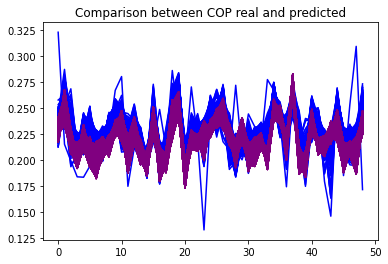

In [57]:
plt.figure()
plt.plot(COPX,color='blue')
plt.plot(COPXreal,color='purple')
plt.title('Comparison between COP real and predicted')
plt.show()

# COP in function of angles

Let's se how the COP correlates with the angles x and z, if the number is closer to 0 than to 1 or -1, the two variables dont correlate. From the graphics we can notice some lack of correlation between them. 

# Correlation between COPX and Angle x

ValueError: x and y must have same first dimension, but have shapes (49, 5970) and (5970,)

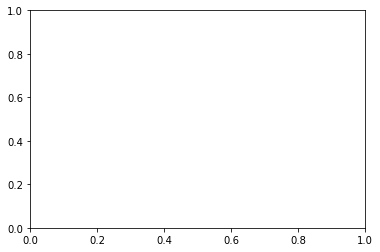

In [61]:
plt.figure()
plt.plot(COPX,matrizangx)
plt.xlabel("Angle ")
plt.ylabel("COPX")
plt.title("Correlation between COPX and Angle x ")
plt.show()

r=np.corrcoef(matrizangx,COPX)
print(r)
plt.figure()
data={'x':matrizangx,
      'y': COPX
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

## Correlation between COPX and anglez

In [ ]:
plt.figure()
plt.plot(COPX,matrizangz)
plt.xlabel("Angle z ")
plt.ylabel("COPX")
plt.title("Correlation between COPX and Angle z ")
plt.show()

r=np.corrcoef(matrizangx,COPX)
print(r)
plt.figure()
data={'x':matrizangz,
      'y': COPX
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

# Error in function of angles

We are going to correlate the error found with angle x and z. If the number is closer to 0 than to 1 or -1, the two variables dont correlate. From the graphics we can notice that the number of correlation approaches -1, indicating a negative correlation betweem them, for the errorz and anglez. With angle x it's possible to conclude that they dont correlate. 

## Correlation between errorx and angle x 

ValueError: x and y must have same first dimension, but have shapes (5970,) and (49, 5970)

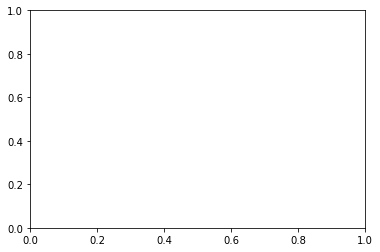

In [62]:
plt.figure()
plt.plot(matrizangx, errorX)
plt.xlabel("Angle x ")
plt.ylabel("Error X")
plt.title("Correlation between Error x and Angle x")
plt.show()

r=np.corrcoef(matrizangx,errorX)
print(r)
plt.figure()
data={'x':matrizangx,
      'y': errorX
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

## Correlation between errorx and anglez

In [ ]:
plt.figure()
plt.plot(errorX,matrizangz)
plt.xlabel("Angle z ")
plt.ylabel("Error X")
plt.title("Correlation between Error X and Angle z ")
plt.show()

r=np.corrcoef(matrizangx,errorX)
print(r)
plt.figure()
data={'x':matrizangz,
      'y': errorX
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

# Error in function of trigonometry

We are going to correlate the error found with the trigonometry angle x and z. If the number is closer to 0 than to 1 or -1, the two variables dont correlate. From the graphics we can notice that the number of correlation approaches -1, inidicating a negative correlation betweem them, for the errorz and trigonometry of the anglez. With angle x it's possible to conclude that they dont correlate. 

## Error x and senx, cosx and tanx

In [63]:
plt.figure()
plt.plot(sinx[30:],errorx,color='blue',label='Sen x')
plt.plot(cosx[30:],errorx,color='red',label='Cos x')
plt.plot(tanx[30:],errorx,color='purple',label='Tan x')
plt.xlabel("Trigonometry ")
plt.ylabel("Error x")
plt.legend()
plt.show()

plt.plot(sinx[30:],errorx)
plt.xlabel("Sin x")
plt.ylabel("Error x")
plt.title("Correlation between error x and Sin x")
plt.show()
r=np.corrcoef(sinx[30:],errorx)
print(r)
plt.figure()
data={'x':sinx[30:],
      'y': errorx
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()
    
plt.plot(cosx[30:],errorx)
plt.xlabel("Cos x")
plt.ylabel("Error x")
plt.title("Correlation between error x and Cos x")
plt.show()
r=np.corrcoef(cosx[30:],errorx)
print(r)
plt.figure()
data={'x':cosx[30:],
      'y': errorx
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

plt.plot(tanx[30:],errorx)
plt.xlabel("Tan x")
plt.ylabel("Error x")
plt.title("Correlation between error x and Tan x")
plt.show()
r=np.corrcoef(tanx[30:],errorx)
print(r)
plt.figure()
data={'x':tanx[30:],
      'y': errorx
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

NameError: name 'errorx' is not defined

<Figure size 432x288 with 0 Axes>

## Correlation between errorx and sen,cos and tan of z

In [63]:
plt.figure()
plt.plot(sinz[30:],errorx,color='blue',label='Sen z')
plt.plot(cosz[30:],errorx,color='red',label='Cos z')
plt.plot(tanz[30:],errorx,color='purple',label='Tan z')
plt.xlabel("Trigonometry ")
plt.ylabel("Error x")
plt.legend()
plt.show()

plt.plot(sinz[30:],errorx)
plt.xlabel("Sin z")
plt.ylabel("Error x")
plt.title("Correlation between error x and Sin z")
plt.show()
r=np.corrcoef(sinz[30:],errorx)
print(r)
plt.figure()
data={'x':sinz[30:],
      'y': errorx
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()
    
plt.plot(cosz[30:],errorx)
plt.xlabel("Cos z")
plt.ylabel("Error x")
plt.title("Correlation between error x and Cos z")
plt.show()
r=np.corrcoef(cosz[30:],errorx)
print(r)
plt.figure()
data={'x':cosz[30:],
      'y': errorx
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

plt.plot(tanz[30:],errorx)
plt.xlabel("Tan z")
plt.ylabel("Error x")
plt.title("Correlation between error x and Tan z")
plt.show()
r=np.corrcoef(tanz[30:],errorx)
print(r)
plt.figure()
data={'x':tanz[30:],
      'y': errorx
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()

NameError: name 'errorx' is not defined

<Figure size 432x288 with 0 Axes>

# Error x in function of derivatives

We are going to correlate the error found with the first and second. If the number is closer to 0 than to 1 or -1, the two variables dont correlate. From the graphics we can notice that the number of correlation approaches 0, indicating a lack of correlation betweem them, for the errorz and anglez and angle x for the first and second derivative.

## Correlation between errorx and first and second derivative of x

In [64]:
plt.figure()
plt.plot(d1x,errorx,color='blue',label='First derivative')
plt.plot(d2x,errorx,color='red',label='Second derivative')
plt.xlabel("Derivative")
plt.ylabel("Error x")
plt.legend()
plt.show()

plt.plot(d1x,errorx,'bo')
plt.xlabel("First derivative x")
plt.ylabel("Errorx")
plt.title("Correlation between error x and First derivative x ")
plt.show()
r=np.corrcoef(d1x,errorx)
print(r)
plt.figure()
data={'x':d1x,
      'y': errorx,
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()
plt.plot(d2x,errorx)
plt.xlabel("Second derivative x")
plt.ylabel("Error x")
plt.title("Correlation between error x and Second deivative  x ")
plt.show()
r=np.corrcoef(d2x,errorx)
print(r)
plt.figure()
data={'x':d2x,
      'y': errorx,
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()
    

NameError: name 'errorx' is not defined

<Figure size 432x288 with 0 Axes>

## Correlation between errorx and first and second derivative of z

In [ ]:
plt.figure()
plt.plot(d1z,errorx,color='blue',label='First derivative')
plt.plot(d2z,errorx,color='red',label='Second derivative')
plt.xlabel("Derivative")
plt.ylabel("Error x")
plt.legend()
plt.show()

plt.plot(d1z,errorx,'bo')
plt.xlabel("First derivative z")
plt.ylabel("Errorx")
plt.title("Correlation between error x and First derivative z")
plt.show()
r=np.corrcoef(d1z,errorx)
print(r)
plt.figure()
data={'x':d1z,
      'y': errorx,
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()
plt.plot(d2z,errorx)
plt.xlabel("Second derivative z")
plt.ylabel("Error x")
plt.title("Correlation between error x and Second deivative z ")
plt.show()
r=np.corrcoef(d2z,errorx)
print(r)
plt.figure()
data={'x':d2z,
      'y': errorx,
     }
df=pd.DataFrame(data)
correlation=df.corr()
plot=sns.heatmap(correlation,annot= True, fmt='.1f',linewidths=.6)
plt.show()
    